<img src="https://docs.dask.org/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">

# dask.delayed - parallelize any code

What if you don't have an array or dataframe? Instead of having blocks where the function is applied to each block, you can decorate functions with `@delayed` and _have the functions themselves be lazy_. 

This is a simple way to use `dask` to parallelize existing codebases or build [complex systems](https://blog.dask.org/2018/02/09/credit-models-with-dask). 

**Related Documentation**

* [Delayed documentation](https://docs.dask.org/en/latest/delayed.html)
* [Delayed screencast](https://www.youtube.com/watch?v=SHqFmynRxVU)
* [Delayed API](https://docs.dask.org/en/latest/delayed-api.html)
* [Delayed examples](https://examples.dask.org/delayed.html)
* [Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)

As we'll see in the [distributed scheduler notebook](05_distributed.ipynb), Dask has several ways of executing code in parallel. We'll use the distributed scheduler by creating a `dask.distributed.Client`. For now, this will provide us with some nice diagnostics. We'll talk about schedulers in depth later.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 7.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34865,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.49 GiB
Comm: tcp://127.0.0.1:35751,Total threads: 2
Dashboard: http://127.0.0.1:37107/status,Memory: 1.87 GiB
Nanny: tcp://127.0.0.1:44363,


## A Typical Workflow

Typically if a workflow contains a for-loop it can benefit from delayed. The following example outlines a read-transform-write:

```python
import dask
    
@dask.delayed
def process_file(filename):
    data = read_a_file(filename)
    data = do_a_transformation(data)
    destination = f"results/{filename}"
    write_out_data(data, destination)
    return destination

results = []
for filename in filenames:
    results.append(process_file(filename))
    
dask.compute(results)
```

## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next section we'll parallelize this code.

In [2]:
from time import sleep


def inc(x):
    sleep(1)
    return x + 1


def add(x, y):
    sleep(1)
    return x + y

We time the execution of this normal code using the `%%time` magic, which is a special function of the Jupyter Notebook.

In [3]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 239 ms, sys: 27.3 ms, total: 266 ms
Wall time: 3 s


### Parallelize with the `dask.delayed` decorator

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

We'll make the `inc` and `add` functions lazy using the `dask.delayed` decorator. When we call the delayed version by passing the arguments, exactly as before, the original function isn't actually called yet - which is why the cell execution finishes very quickly.
Instead, a *delayed object* is made, which keeps track of the function to call and the arguments to pass to it.


In [4]:
import dask


@dask.delayed
def inc(x):
    sleep(1)
    return x + 1


@dask.delayed
def add(x, y):
    sleep(1)
    return x + y

In [5]:
%%time
# This runs immediately, all it does is build a graph

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 0 ns, sys: 1.86 ms, total: 1.86 ms
Wall time: 5.83 ms


This ran immediately, since nothing has really happened yet.

To get the result, call `compute`. Notice that this runs faster than the original code.

In [6]:
%%time
# This actually runs our computation using a local thread pool

z.compute()

CPU times: user 288 ms, sys: 45.6 ms, total: 334 ms
Wall time: 2.17 s


5

## What just happened?

The `z` object is a lazy `Delayed` object.  This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.  We can evaluate the result with `.compute()` as above or we can visualize the task graph for this value with `.visualize()`.

In [7]:
z

Delayed('add-123963fb-1cbd-44a5-a926-1f3db8883a88')

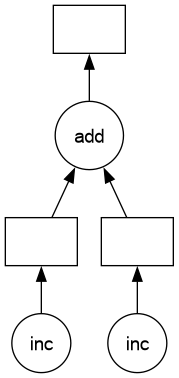

In [8]:
# Look at the task graph for `z`
z.visualize()

Notice that this includes the names of the functions from before, and the logical flow of the outputs of the `inc` functions to the inputs of `add`.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelize a for loop

`for` loops are one of the most common things that we want to parallelize.  Use `dask.delayed` on `inc` and `sum` to parallelize the computation below:

In [9]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [10]:
%%time
# Sequential code


def inc(x):
    sleep(1)
    return x + 1


results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)

CPU times: user 619 ms, sys: 42 ms, total: 661 ms
Wall time: 8.01 s


In [11]:
total

44

In [12]:
%%time

@dask.delayed
def inc(x):
    sleep(1)
    return x + 1


results = []
for x in data:
    y = inc(x)
    results.append(y)

total = sum(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed

Before computing: Delayed('add-e535b4c37bb0a20aceb57c99eef2e4c8')
After computing : 44
CPU times: user 114 ms, sys: 15.1 ms, total: 129 ms
Wall time: 1.08 s


How do the graph visualizations compare with the given solution, compared to a version with the `sum` function used directly rather than wrapped with `delayed`? Can you explain the latter version? You might find the result of the following expression illuminating
```python
inc(1) + inc(2)
```

## Exercise: Parallelize a for-loop code with control flow

Often we want to delay only *some* functions, running a few of them immediately.  This is especially helpful when those functions are fast and help us to determine what other slower functions we should call.  This decision, to delay or not to delay, is usually where we need to be thoughtful when using `dask.delayed`.

In the example below we iterate through a list of inputs.  If that input is even then we want to call `inc`.  If the input is odd then we want to call `double`.  This `is_even` decision to call `inc` or `double` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [13]:
def double(x):
    sleep(1)
    return 2 * x


def is_even(x):
    return not x % 2


data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [14]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)

total = sum(results)
print(total)

Delayed('add-673003a54008e63a642cbd69b45d10c5')
CPU times: user 414 ms, sys: 19.8 ms, total: 434 ms
Wall time: 5.01 s


In [15]:
%%time
# Your parallel code here...
# TODO: parallelize the sequential code above using dask.delayed
# You will need to delay some functions, but not all

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


In [16]:
@dask.delayed
def double(x):
    sleep(1)
    return 2 * x


results = []
for x in data:
    if is_even(x):  # even
        y = double(x)
    else:  # odd
        y = inc(x)
    results.append(y)

total = sum(results)

In [17]:
%time total.compute()

CPU times: user 181 ms, sys: 39.4 ms, total: 220 ms
Wall time: 2.05 s


90

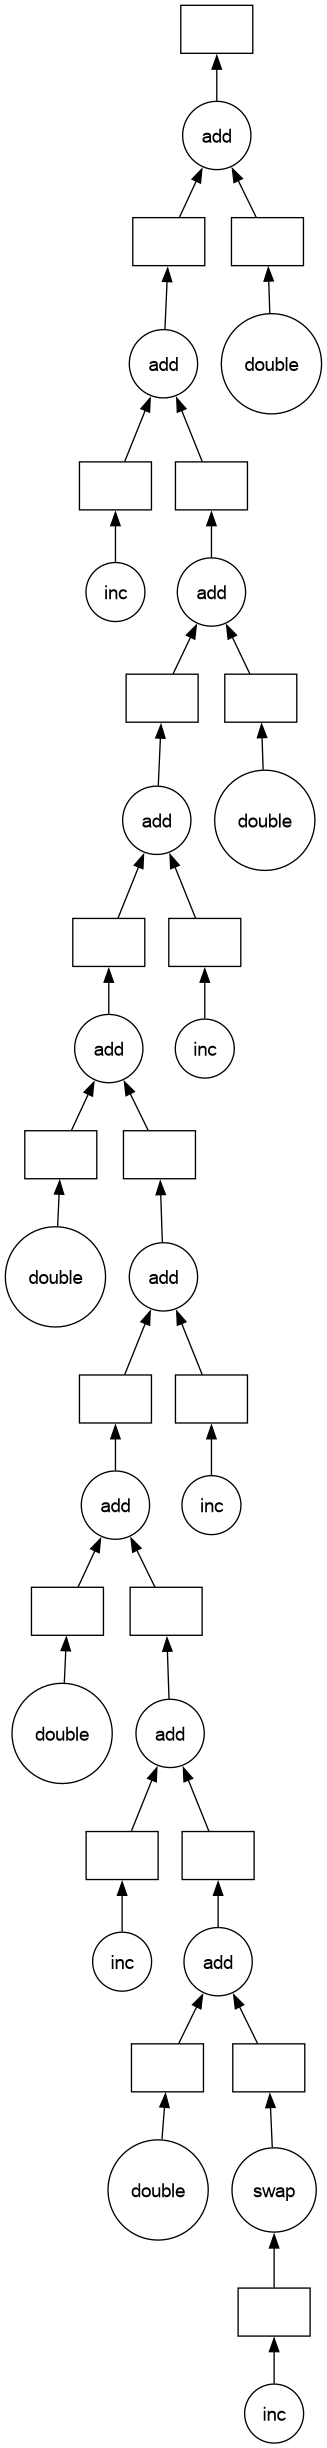

In [18]:
total.visualize()

### Some questions to consider:

-  What are other examples of control flow where we can't use delayed?
-  What would have happened if we had delayed the evaluation of `is_even(x)` in the example above?
-  What are your thoughts on delaying `sum`?  This function is both computational but also fast to run.

## Close the Client

In [19]:
client.close()